In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping

from keras.preprocessing.image import load_img

In [3]:
from keras.preprocessing.image import ImageDataGenerator

train = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_data = train.flow_from_directory(directory='/content/gdrive/MyDrive/DATASET/TRAIN',
                                       target_size=(224, 224),
                                       batch_size=32,
                                       class_mode='categorical')

validation_data = train.flow_from_directory(directory='/content/gdrive/MyDrive/DATASET/TRAIN',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='categorical')

Found 1998 images belonging to 3 classes.
Found 1998 images belonging to 3 classes.


In [4]:
test=ImageDataGenerator(rescale=1./255)
test_data=test.flow_from_directory(directory = '/content/gdrive/MyDrive/DATASET/TEST',target_size=(224,224),
                                   batch_size=32,class_mode='categorical')

Found 1998 images belonging to 3 classes.


Found 1998 files belonging to 3 classes.


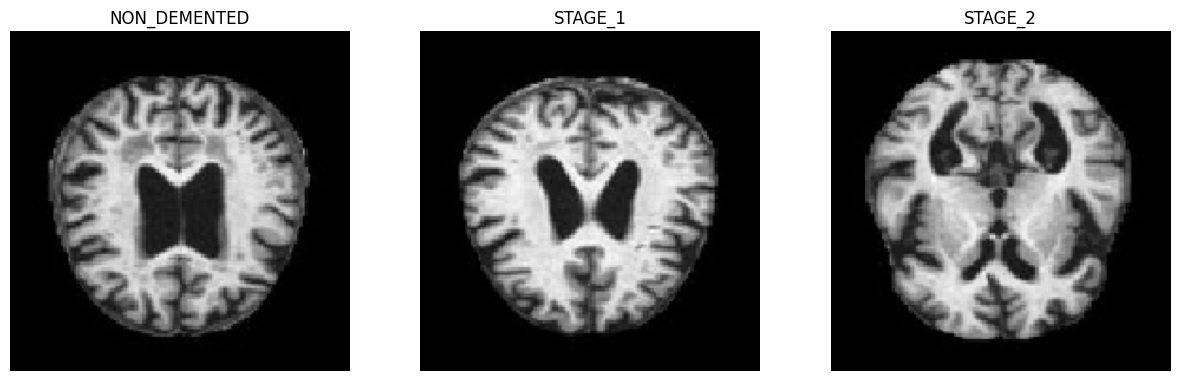

In [6]:
#Visualize one instance of all the class present in the dataset.
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/DATASET/TRAIN")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/DATASET/TEST")

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [59]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,NON_DEMENTED,666
1,STAGE_2,666
2,STAGE_1,666


<Axes: xlabel='No. of Image', ylabel='Class'>

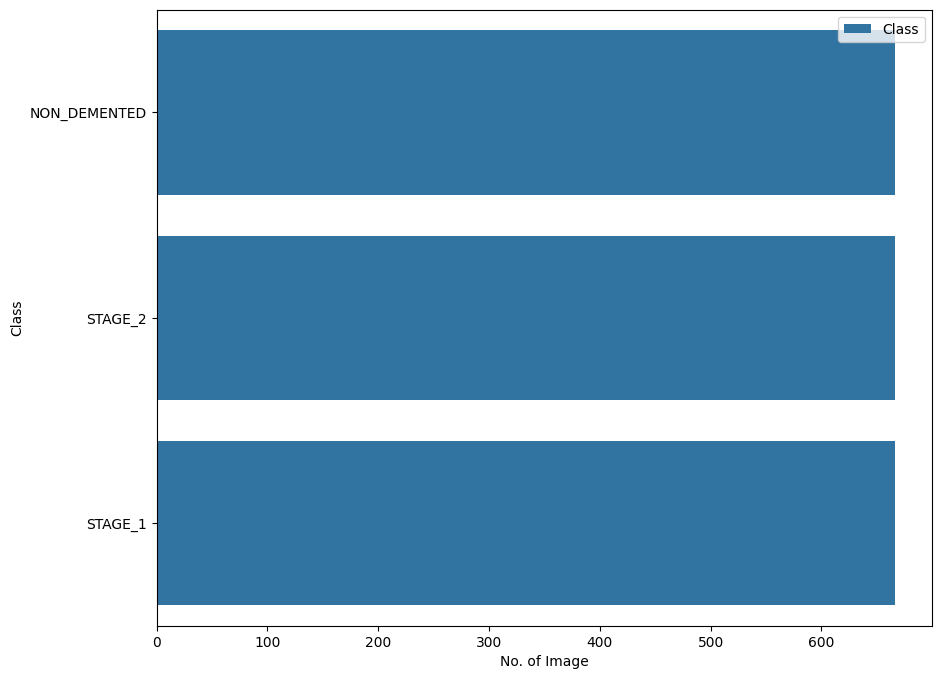

In [8]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

In [9]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 1998 files belonging to 3 classes.
Using 1599 files for training.


In [10]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 1998 files belonging to 3 classes.
Using 399 files for validation.


In [60]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [61]:
from tensorflow import keras
from tensorflow.keras import layers

# Create a Sequential model
model = keras.Sequential()

# Data Preprocessing
model.add(layers.experimental.preprocessing.Rescaling(1.0 / 255, input_shape=(180, 180, 3)))  # Rescaling Layer

# CNN Layers for Feature Extraction
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten the output from the CNN layers
model.add(layers.TimeDistributed(layers.Flatten()))

# LSTM Layer without return_sequences
model.add(layers.LSTM(128, activation='tanh'))

# Dense Layer
model.add(layers.Dense(128, activation='relu'))

# Output Layer with softmax activation function and output shape (None, 9)
model.add(layers.Dense(3, activation='softmax'))  # Change the number of units to 9

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 41, 41, 128)      

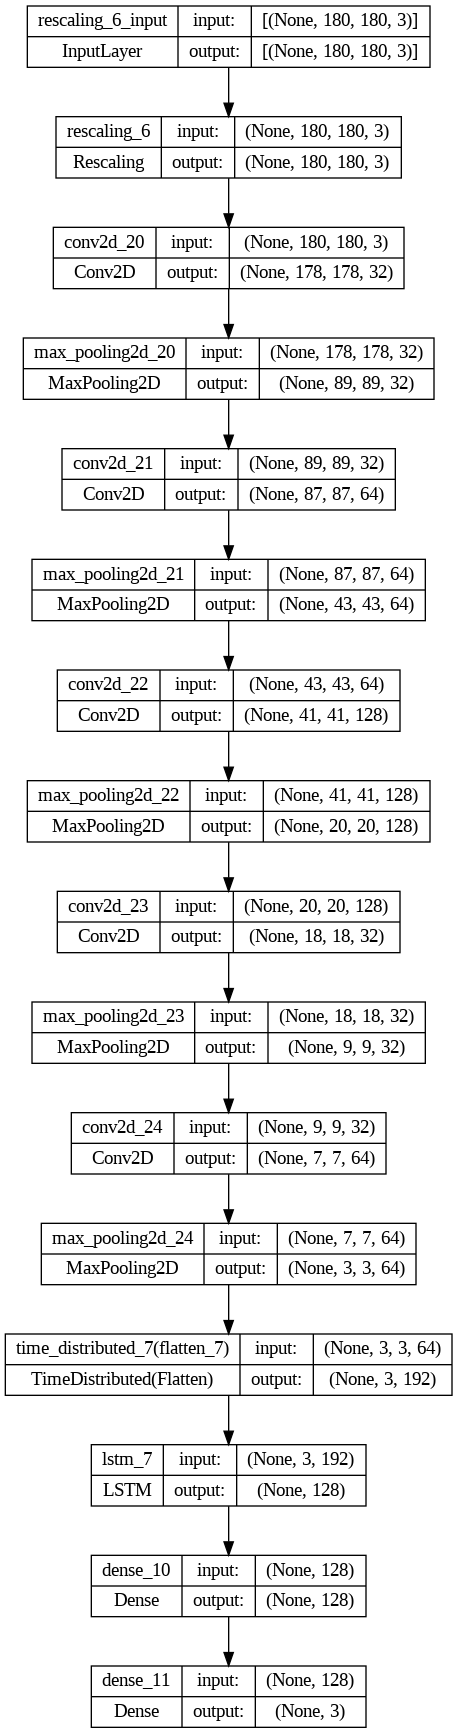

In [62]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [63]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

checkpoint = ModelCheckpoint("model2.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [64]:
epochs = 40
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[earlystop, checkpoint])

Epoch 1/40
50/50 [==============================] - ETA: 0s - loss: 1.0087 - accuracy: 0.4628
Epoch 1: val_accuracy improved from -inf to 0.75940, saving model to model2.h5
50/50 [==============================] - 122s 2s/step - loss: 1.0087 - accuracy: 0.4628 - val_loss: 0.6091 - val_accuracy: 0.7594


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/40
50/50 [==============================] - ETA: 0s - loss: 0.6355 - accuracy: 0.7067
Epoch 2: val_accuracy did not improve from 0.75940
50/50 [==============================] - 115s 2s/step - loss: 0.6355 - accuracy: 0.7067 - val_loss: 0.5918 - val_accuracy: 0.7594
Epoch 3/40
50/50 [==============================] - ETA: 0s - loss: 0.5846 - accuracy: 0.7342
Epoch 3: val_accuracy did not improve from 0.75940
50/50 [==============================] - 117s 2s/step - loss: 0.5846 - accuracy: 0.7342 - val_loss: 0.5564 - val_accuracy: 0.7544
Epoch 4/40
50/50 [==============================] - ETA: 0s - loss: 0.5553 - accuracy: 0.7423
Epoch 4: val_accuracy improved from 0.75940 to 0.76441, saving model to model2.h5
50/50 [==============================] - 113s 2s/step - loss: 0.5553 - accuracy: 0.7423 - val_loss: 0.5439 - val_accuracy: 0.7644
Epoch 5/40
50/50 [==============================] - ETA: 0s - loss: 0.5219 - accuracy: 0.7598
Epoch 5: val_accuracy improved from 0.76441 to 0.7

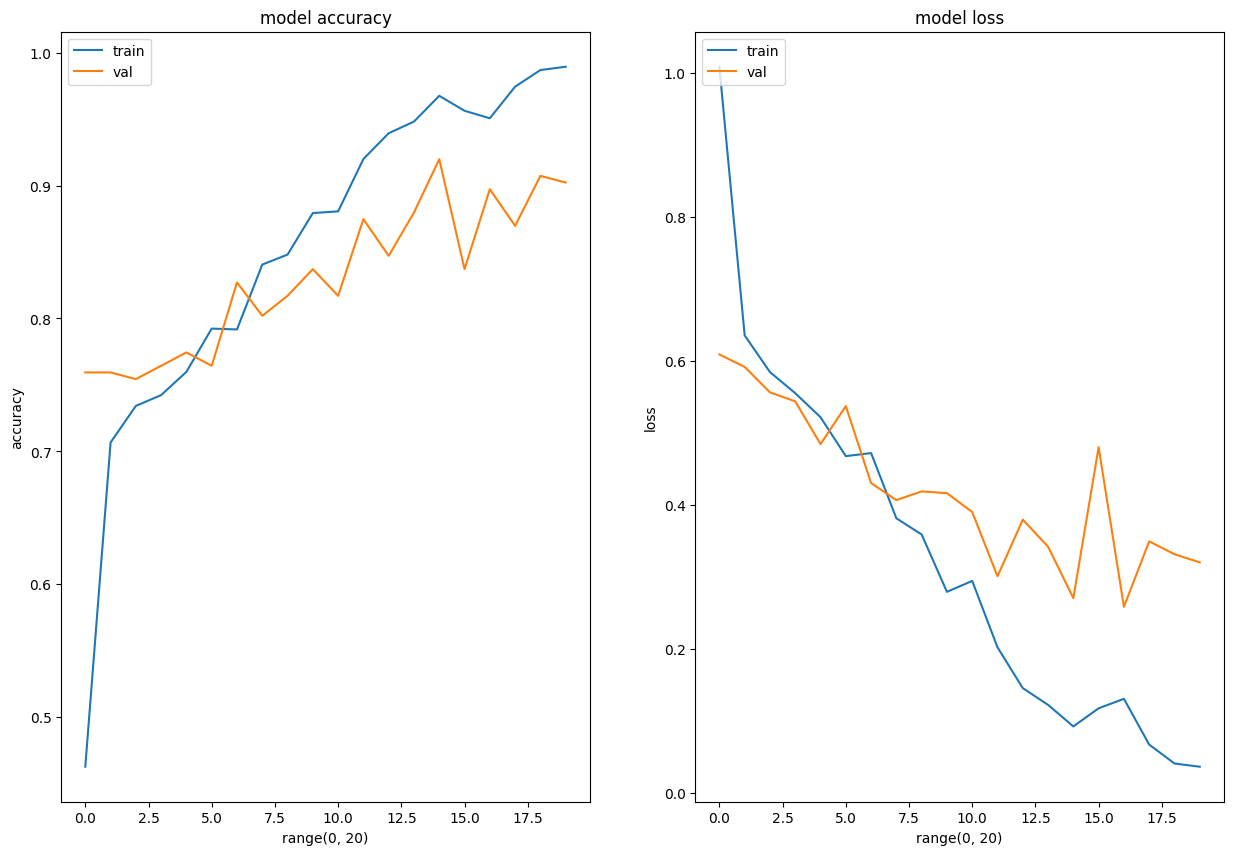

In [65]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()


1/1 [==============================] - 1s 520ms/step
Actual Class STAGE_1
Predictive Class STAGE_1


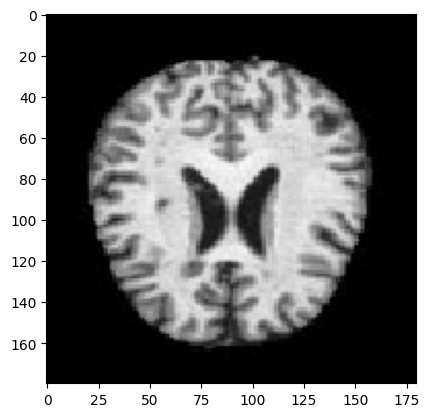

In [66]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

Found 1998 images belonging to 3 classes.
Found 1998 images belonging to 3 classes.
63/63 [==============================] - 46s 713ms/step
Class 0: Optimal Threshold = 0.5, Precision = 0.0000, Recall = 0.0000
Class 1: Optimal Threshold = 0.5, Precision = 0.0000, Recall = 0.0000
Class 2: Optimal Threshold = 0.5, Precision = 0.0000, Recall = 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


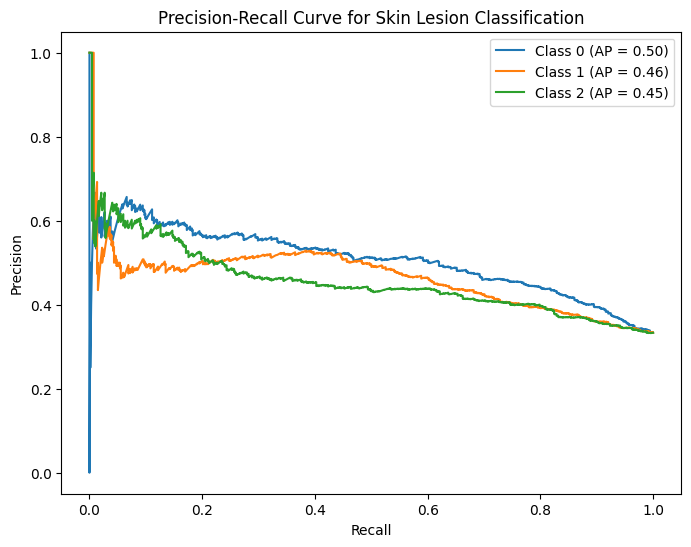

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib

# # Assuming you have a function to load your dataset and preprocess images
# def load_and_preprocess_data(data_dir):
#     # Your data loading and preprocessing code here
#     # Return features, labels
#     pass
# Assuming you have a skin lesion classification model
# Load your model
# Assuming you have a skin lesion classification model
# Load your model
model = load_model("/content/model2.h5")

# Load and preprocess your dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/DATASET/TEST")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/DATASET/TEST")

# Use the ImageDataGenerator for loading and augmenting images
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

# Load and preprocess training data
train_generator = datagen.flow_from_directory(
    data_dir_train,
    target_size=(180, 180),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Load and preprocess testing data
test_generator = datagen.flow_from_directory(
    data_dir_test,
    target_size=(180, 180),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Do not shuffle test data for evaluation
)

# Make predictions on the test set
predictions = model.predict(test_generator)

# Binarize the labels
num_classes = len(train_generator.class_indices)
binarized_labels = label_binarize(test_generator.classes, classes=range(num_classes))

# Compute Precision-Recall curve and area under the curve (AUC) for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(binarized_labels[:, i], predictions[:, i])
    average_precision[i] = auc(recall[i], precision[i])

    # Set a threshold for optimal precision-recall balance (you may need to adjust this)
    optimal_threshold = 0.5

    # Apply the threshold to the predictions
    thresholded_predictions = (predictions[:, i] > optimal_threshold).astype(int)

    # Calculate precision and recall with the chosen threshold
    class_precision = precision_score(binarized_labels[:, i], thresholded_predictions)
    class_recall = recall_score(binarized_labels[:, i], thresholded_predictions)

    print(f"Class {i}: Optimal Threshold = {optimal_threshold}, Precision = {class_precision:.4f}, Recall = {class_recall:.4f}")

# Plot Precision-Recall curve for each class
plt.figure(figsize=(8, 6))

for i in range(num_classes):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Skin Lesion Classification')
plt.legend()
plt.show()

13/13 [==============================] - 9s 618ms/step


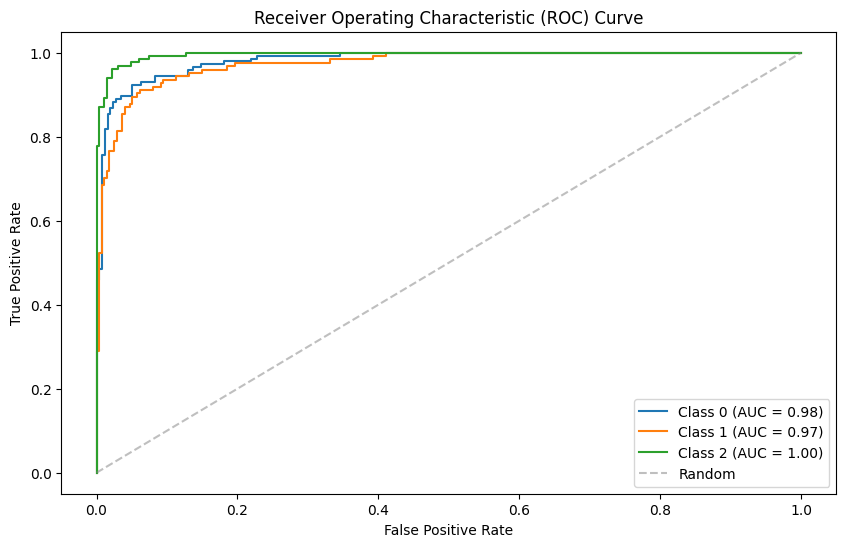

Weighted F1-score: 0.9197


In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier

# Assuming you have a separate test dataset for evaluation
# Split the data into features and labels
X_test, y_test = zip(*[(image, label) for images, labels in val_ds for image, label in zip(images.numpy(), labels.numpy())])
X_test = np.array(X_test)
y_test = np.array(y_test)

# Binarize the labels for the ROC curve
y_test_bin = label_binarize(y_test.argmax(axis=1), classes=list(range(9)))

# Make predictions on the test set
y_pred = model.predict(X_test)

# Plot ROC curve for each class (one-vs-rest)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Calculate and print F1-score
y_pred_classes = y_pred.argmax(axis=1)
f1 = f1_score(y_test.argmax(axis=1), y_pred_classes, average='weighted')
print(f'Weighted F1-score: {f1:.4f}')

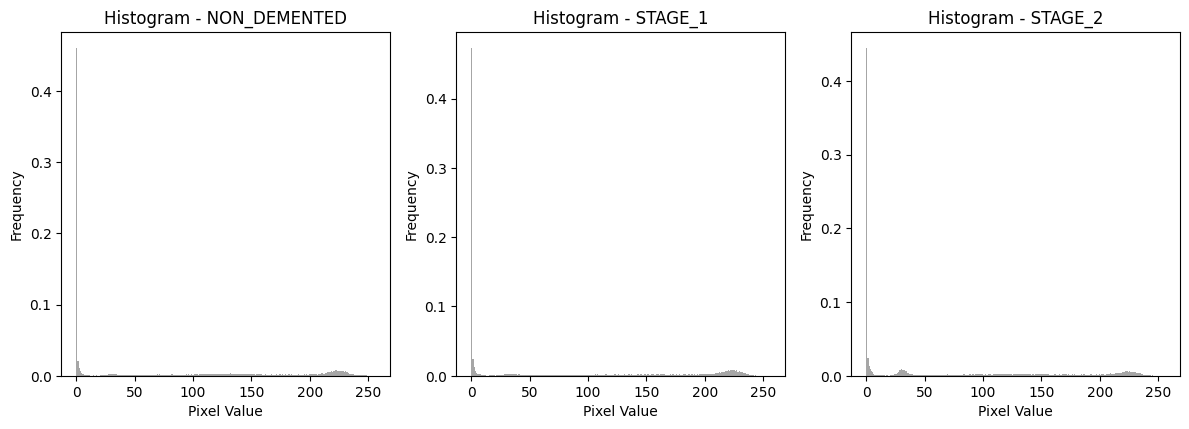

In [70]:
import cv2
import matplotlib.pyplot as plt
import os

# Assuming 'images' is a list containing file paths to one image per class
images = [
    '/content/gdrive/MyDrive/DATASET/TRAIN/NON_DEMENTED/non_39.jpg',
    '/content/gdrive/MyDrive/DATASET/TRAIN/STAGE_1/verymild_355.jpg',
    '/content/gdrive/MyDrive/DATASET/TRAIN/STAGE_2/mild_3.jpg',

]

# Function to plot histogram
def plot_histogram(image_path, position):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Flatten the 2D array (image) to 1D
    pixels = image.flatten()

    # Extract class name from the image path
    class_name = os.path.basename(os.path.dirname(image_path))

    # Plot histogram with class name in the title
    plt.subplot(3, 3, position)
    plt.hist(pixels, bins=256, range=[0, 256], density=True, color='gray', alpha=0.7)
    plt.title(f'Histogram - {class_name}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

# Create a 3x3 grid of histograms
plt.figure(figsize=(12, 12))

# Iterate over images and plot histograms
for i, image_path in enumerate(images, 1):
    plot_histogram(image_path, i)

plt.tight_layout()
plt.show()


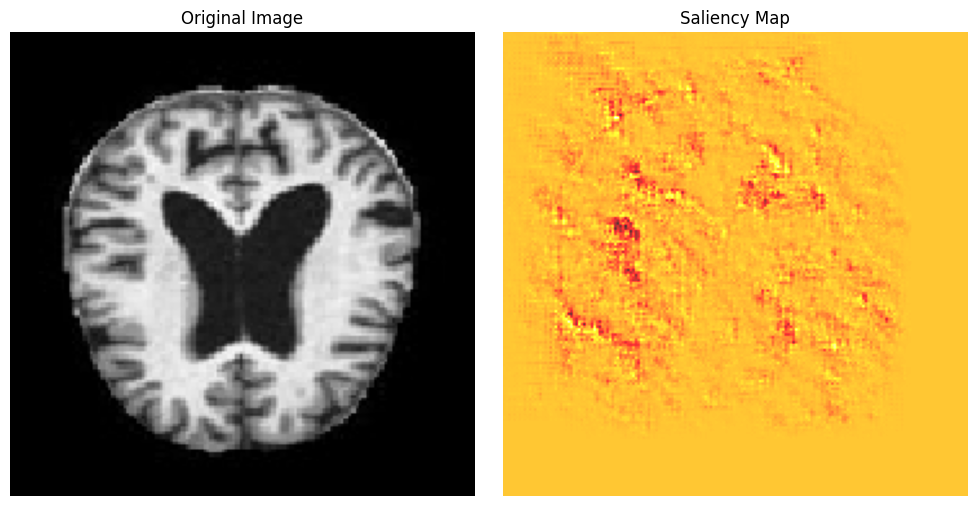

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# Load your trained CNN model
# Replace 'your_model_path.h5' with the path to your trained model
model = tf.keras.models.load_model('model2.h5')

# Function to preprocess input image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(180, 180))  # Resize to match your model's input size
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # Normalize pixel values
    return tf.convert_to_tensor(x)

# Function to generate saliency map
def generate_saliency_map(model, img_path, target_class_index):
    x = preprocess_image(img_path)

    with tf.GradientTape() as tape:
        tape.watch(x)
        preds = model(x)
        loss = preds[:, target_class_index]

    grads = tape.gradient(loss, x)[0]
    grads_normalized = tf.divide(grads, tf.reduce_max(tf.abs(grads)))  # Normalize gradients
    saliency_map = tf.reduce_max(grads_normalized, axis=-1)

    return saliency_map.numpy()

# Load an image
img_path = '/content/gdrive/MyDrive/DATASET/TRAIN/STAGE_2/mild_3.jpg'  # Replace with the path to your input image

# Choose a target class index
# If your model is for binary classification, use 0 for negative class and 1 for positive class
# For multi-class classification, choose the index corresponding to the class you're interested in
target_class_index = 0

# Generate the saliency map
saliency_map = generate_saliency_map(model, img_path, target_class_index)

# Adjust the saliency map for visualization
saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())  # Normalize between 0 and 1
saliency_map = 1 - saliency_map  # Invert the saliency map
saliency_map = np.uint8(255 * saliency_map)  # Convert to uint8 for plotting

# Plot the original image and the saliency map
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.load_img(img_path, target_size=(180, 180)))  # Resize to match your model's input size
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(saliency_map, cmap='hot', alpha=0.8)  # Adjust alpha to control the overlay transparency
plt.title('Saliency Map')
plt.axis('off')

plt.tight_layout()
plt.show()
